In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # 进度条工具

import torch
import torch.nn as nn
import torch.nn.functional as F
# transforms提供了数据处理工具
import torchvision.transforms as transforms 
# 由于数据集较大，我们通过工具在线下载数据集
from torchvision.datasets import CIFAR10 
from torch.utils.data import DataLoader

训练集大小： 50000
测试集大小： 10000


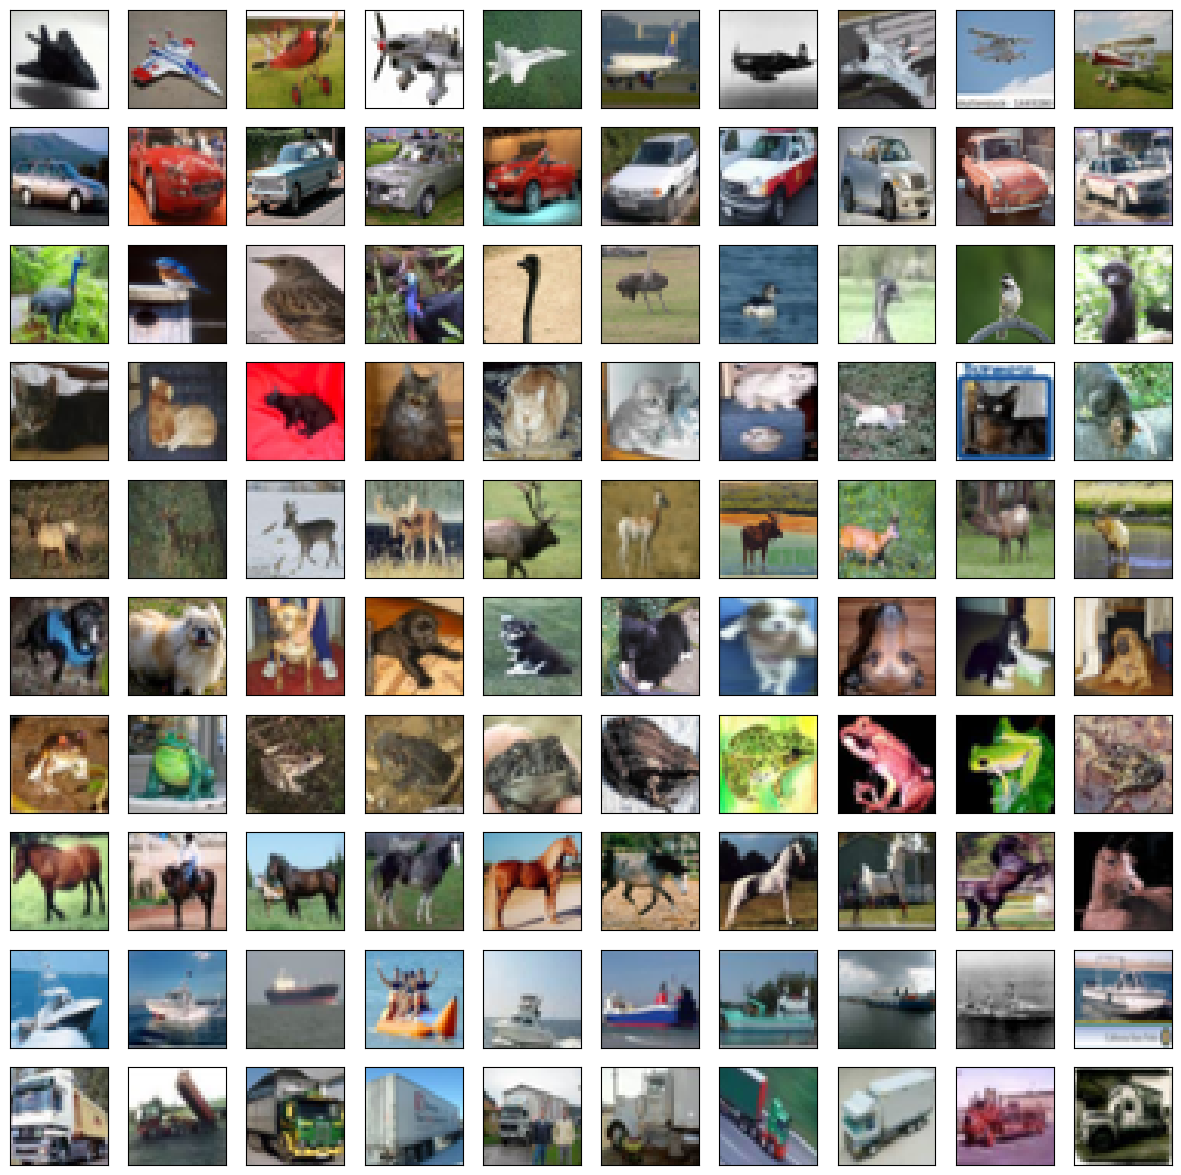

In [57]:
# 下载训练集和测试集
data_path = './cifar10'
trainset = CIFAR10(root=data_path, train=True, 
    download=True, transform=transforms.ToTensor())
testset = CIFAR10(root=data_path, train=False, 
    download=True, transform=transforms.ToTensor())
print('训练集大小：', len(trainset))
print('测试集大小：', len(testset))
# trainset和testset可以直接用下标访问
# 每个样本为一个元组 (data, label)
# data是3*32*32的Tensor，表示图像
# label是0-9之间的整数，代表图像的类别

# 可视化数据集
num_classes = 10
fig, axes = plt.subplots(num_classes, 10, figsize=(15, 15))
labels = np.array([t[1] for t in trainset]) # 取出所有样本的标签
# •  trainset 是一个 PyTorch 的 Dataset 对象（具体是 torchvision.datasets.CIFAR10 的实例）。
# •  它支持迭代，每次迭代返回一个元组 t = (data, label)：
#   ⁠◦  data: 图像张量，形状为 [3, 32, 32]
#   ⁠◦  label: 整数，表示图像的类别（0–9）
for i in range(num_classes):
    indice = np.where(labels == i)[0] # 类别为i的图像的下标
    for j in range(10): # 展示前10张图像
        # matplotlib绘制RGB图像时
        # 图像矩阵依次是宽、高、颜色，与数据集中有差别
        # 因此需要用permute重排数据的坐标轴
        axes[i][j].imshow(trainset[indice[j]][0].permute(1, 2, 0).numpy())
        # 去除坐标刻度
        axes[i][j].set_xticks([]) 
        axes[i][j].set_yticks([])
plt.show()

In [58]:
import torch
from torch import nn
import torch.nn.functional as F

class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=strides, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.use_1x1conv = use_1x1conv
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                   stride=strides, bias=False)
            self.bn3 = nn.BatchNorm2d(out_channels)
        else:
            self.conv3 = None

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.bn3(self.conv3(X))
        Y += X
        return F.relu(Y)

In [69]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                   nn.BatchNorm2d(64), nn.ReLU(inplace=True)
                   )

In [70]:
def resnet_block(in_channels, out_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            # stage 的第一个 block：降采样 + 通道匹配
            blk.append(Residual(in_channels, out_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(out_channels, out_channels))
    return blk

In [71]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [74]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [77]:
lr, num_epoch, batch_size = 1e-3, 10, 64  # 用 Adam 建议从 1e-3 开始
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader  = DataLoader(testset,  batch_size=batch_size, shuffle=False)

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        return torch.device("mps")
    return torch.device("cpu")

device = get_device()

criterion = nn.CrossEntropyLoss()
model = net.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def evaluate():
    model.eval()
    loss_sum, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)  # 移到 device
            logits = model(x)
            loss_sum += criterion(logits, y).item() * y.size(0)
            preds = logits.argmax(1)           # 先 argmax 再比对
            correct += (preds == y).sum().item()
            total += y.size(0)
    return loss_sum / total, correct / total

for epoch in range(num_epoch):
    model.train()
    running_loss, running_correct, running_total = 0.0, 0, 0
    for i, (x, y) in enumerate(trainloader, 1):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        running_total += y.size(0)

        # 可选：增加简单进度输出，避免长时间无打印
        if i == 1 or i % 50 == 0:
            print(f"Epoch {epoch+1} Step {i}/{len(trainloader)} "
                  f"loss {running_loss/running_total:.4f} acc {running_correct/running_total:.4f}")

    val_loss, val_acc = evaluate()
    print(f"Epoch {epoch+1}: val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

Epoch 1 Step 1/782 loss 1.1947 acc 0.5781
Epoch 1 Step 50/782 loss 1.4381 acc 0.4644
Epoch 1 Step 100/782 loss 1.4169 acc 0.4811
Epoch 1 Step 150/782 loss 1.3858 acc 0.4939
Epoch 1 Step 200/782 loss 1.3528 acc 0.5032
Epoch 1 Step 250/782 loss 1.3211 acc 0.5153
Epoch 1 Step 300/782 loss 1.2972 acc 0.5252
Epoch 1 Step 350/782 loss 1.2749 acc 0.5346
Epoch 1 Step 400/782 loss 1.2553 acc 0.5414
Epoch 1 Step 450/782 loss 1.2374 acc 0.5480
Epoch 1 Step 500/782 loss 1.2151 acc 0.5564
Epoch 1 Step 550/782 loss 1.2007 acc 0.5625
Epoch 1 Step 600/782 loss 1.1854 acc 0.5689
Epoch 1 Step 650/782 loss 1.1701 acc 0.5745
Epoch 1 Step 700/782 loss 1.1544 acc 0.5807
Epoch 1 Step 750/782 loss 1.1406 acc 0.5864
Epoch 1: val_loss=1.1215, val_acc=0.6197
Epoch 2 Step 1/782 loss 0.9892 acc 0.6406
Epoch 2 Step 50/782 loss 0.8574 acc 0.6963
Epoch 2 Step 100/782 loss 0.8374 acc 0.7036
Epoch 2 Step 150/782 loss 0.8302 acc 0.7061
Epoch 2 Step 200/782 loss 0.8285 acc 0.7087
Epoch 2 Step 250/782 loss 0.8212 acc 0.71

KeyboardInterrupt: 